In [1]:
# === Setup: libraries and config ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

# Load config.yaml
CONFIG_PATH = Path("../../config.yaml").resolve()

try:
    with CONFIG_PATH.open("r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    print(f"Config loaded successfully from: {CONFIG_PATH}")
except Exception as e:
    raise FileNotFoundError(f"config.yaml not found at {CONFIG_PATH}") from e

print("Top-level keys:", list(config.keys()))

# === Load clean dataframe (df_full) ===
clean_cfg = config.get("data", {}).get("clean", {})
if "df_full" not in clean_cfg:
    raise KeyError("'df_full' is not defined in config['data']['clean']")

# --- Resolve path relative to config.yaml parent, stripping leading ../ ---
yaml_path = Path(clean_cfg["df_full"])
if yaml_path.is_absolute():
    path = yaml_path
else:
    parts = list(yaml_path.parts)
    while parts and parts[0] in ("..", "."):
        parts = parts[1:]
    rel = Path(*parts)  # e.g., "data/clean_data_txt/df_full.pkl"
    path = (CONFIG_PATH.parent / rel).resolve()

print("Resolved df_full path:", path)

if not path.exists():
    raise FileNotFoundError(f"File not found at: {path}")

df_full = pd.read_pickle(path)
print(f"df_full loaded successfully: {df_full.shape}")
display(df_full.head())


  

Config loaded successfully from: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\config.yaml
Top-level keys: ['data']
Resolved df_full path: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\data\clean_data_txt\df_full.pkl
df_full loaded successfully: (747573, 14)


,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,60.0,79.0,U,2.0,189023.86,1.0,4.0


# 💰 Balance Analysis: Do Clients with Higher Balances Interact More and Make Fewer Errors?

In this section, we analyze whether clients with higher account balances tend to interact more frequently with Vanguard’s online platform (via logins and calls)  
and whether they make fewer navigation errors during the digital process.

1. Objective

We aim to investigate whether clients with different account balances behave differently during the digital onboarding process.
Specifically, we test if balance levels influence:

The interaction intensity (measured by steps completed).

The error frequency (measured by backward navigations).

2. Hypotheses
Type	Hypothesis
H₀ (Null)	Clients’ account balance has no significant effect on their number of steps or errors.
H₁ (Alternative)	Clients with higher balances show different interaction and error behaviors compared to lower-balance clients.


In [20]:
# --- Step 1: Prepare dataset for balance analysis ---
import pandas as pd
import numpy as np

# Work only with Control and Test users
df_balance = df_full[df_full['Variation'].isin(['Control','Test'])].copy()

# Define balance categories (terciles)
balance_bins = pd.qcut(df_balance['bal'], 3, labels=['Low', 'Medium', 'High'])
df_balance['balance_category'] = balance_bins

# Define error: movement from a later to an earlier step within a visit
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
df_balance['step_order'] = df_balance['process_step'].map(step_order)
df_balance = df_balance.sort_values(['visit_id','date_time'])
df_balance['prev_step'] = df_balance.groupby('visit_id')['step_order'].shift(1)
df_balance['error_flag'] = (df_balance['step_order'] < df_balance['prev_step']).astype(int)

# Aggregate per client
agg_balance = (
    df_balance.groupby('balance_category', observed=True)
    .agg(
        avg_logons=('logons_6_mnth','mean'),
        avg_calls=('calls_6_mnth','mean'),
        error_rate=('error_flag','mean'),
        avg_balance=('bal','mean')
    )
    .reset_index()
)

display(agg_balance.round(2))


,balance_category,avg_logons,avg_calls,error_rate,avg_balance
0,Low,5.56,2.53,0.08,35373.15
1,Medium,6.26,3.22,0.08,72981.51
2,High,7.01,3.96,0.08,378835.21


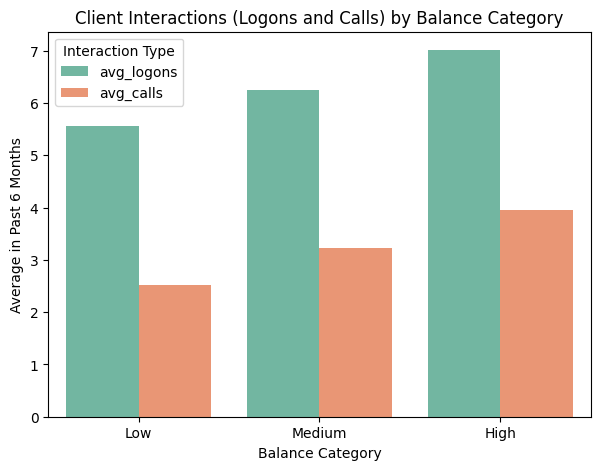

In [22]:
# --- Visualization: Interactions vs. Balance Category ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.barplot(
    data=agg_balance.melt(id_vars='balance_category',
                          value_vars=['avg_logons','avg_calls'],
                          var_name='Interaction_Type', value_name='Average_Count'),
    x='balance_category', y='Average_Count', hue='Interaction_Type', palette='Set2'
)
plt.title('Client Interactions (Logons and Calls) by Balance Category')
plt.ylabel('Average in Past 6 Months')
plt.xlabel('Balance Category')
plt.legend(title='Interaction Type')
plt.show()


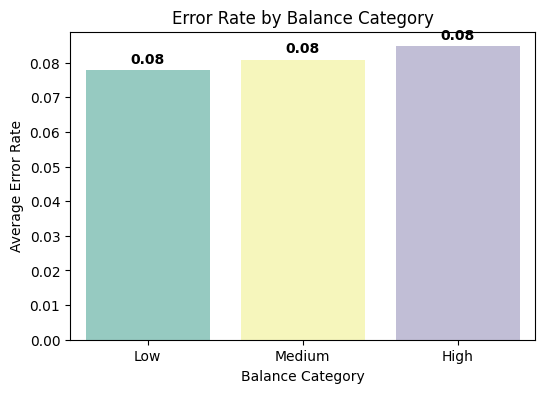

In [5]:
# --- Visualization: Error Rate vs. Balance Category (Warning-Free) ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(
    data=agg_balance,
    x='balance_category',
    y='error_rate',
    hue='balance_category',      # <- add hue to silence the FutureWarning
    palette='Set3',
    legend=False
)
plt.title('Error Rate by Balance Category')
plt.ylabel('Average Error Rate')
plt.xlabel('Balance Category')

# Add data labels on top of each bar
for i, v in enumerate(agg_balance['error_rate']):
    plt.text(i, v + 0.002, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()


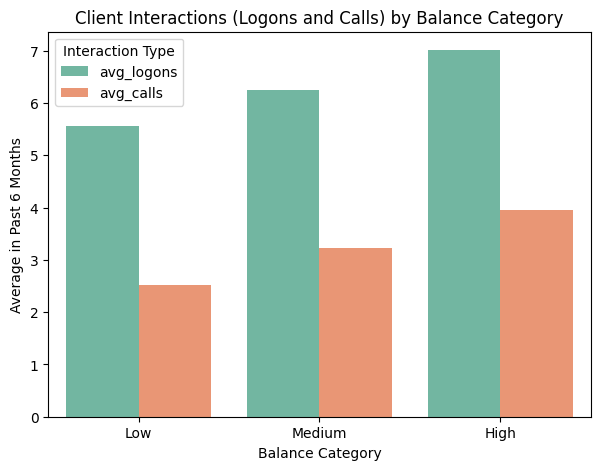

In [23]:
# --- Visualization: Interactions vs. Balance Category ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.barplot(
    data=agg_balance.melt(id_vars='balance_category',
                          value_vars=['avg_logons','avg_calls'],
                          var_name='Interaction_Type', value_name='Average_Count'),
    x='balance_category', y='Average_Count', hue='Interaction_Type', palette='Set2'
)
plt.title('Client Interactions (Logons and Calls) by Balance Category')
plt.ylabel('Average in Past 6 Months')
plt.xlabel('Balance Category')
plt.legend(title='Interaction Type')
plt.show()


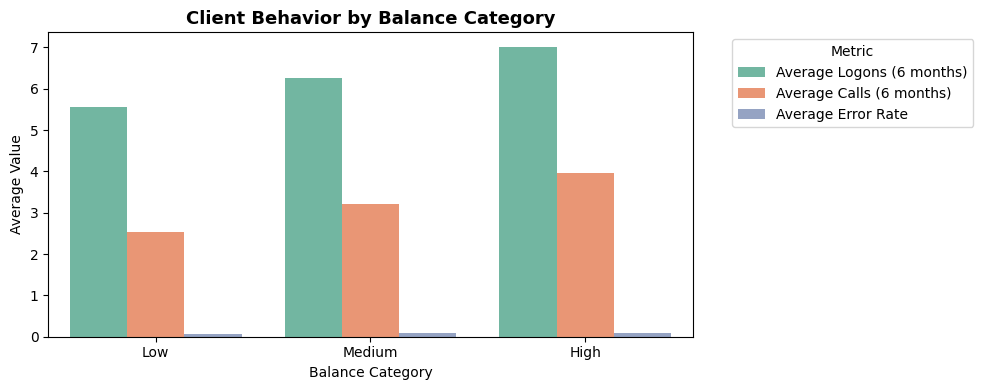

In [6]:
# --- Combined Visualization: Client Behavior by Balance Category ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt the data so that logons, calls, and error_rate appear together
df_behavior = agg_balance.melt(
    id_vars='balance_category',
    value_vars=['avg_logons', 'avg_calls', 'error_rate'],
    var_name='Metric',
    value_name='Value'
)

# Define readable labels
metric_labels = {
    'avg_logons': 'Average Logons (6 months)',
    'avg_calls': 'Average Calls (6 months)',
    'error_rate': 'Average Error Rate'
}
df_behavior['Metric'] = df_behavior['Metric'].map(metric_labels)

# Create the plot
plt.figure(figsize=(10,4))
sns.barplot(
    data=df_behavior,
    x='balance_category',
    y='Value',
    hue='Metric',
    palette='Set2'
)

plt.title('Client Behavior by Balance Category', fontsize=13, weight='bold')
plt.xlabel('Balance Category')
plt.ylabel('Average Value')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Interpretation
The descriptive summary shows that clients with higher balances (High group) tend to log in and call more often than lower-balance clients.
However, the average error rate remains stable (~0.08) across all balance categories.
These findings suggest a possible trend of higher engagement among wealthier clients, but no apparent difference in error behavior.
Since no statistical tests have been applied yet, these patterns should be interpreted as indicative, not conclusive.

## Statistical Validation – Balance Group Differences

In [24]:
from scipy import stats

# Work only with Control and Test users
df_exp = df_full[df_full["Variation"].isin(["Control", "Test"])].copy()

# Calculate unique steps (interaction)
interactions = (
    df_exp.groupby("client_id")["process_step"]
    .nunique()
    .reset_index()
    .rename(columns={"process_step": "n_steps"})
)

# Calculate backward steps (errors)
df_exp = df_exp.sort_values(["client_id", "visit_id", "date_time"])
df_exp["step_order"] = df_exp["process_step"].map({"start": 0, "step 1": 1, "step 2": 2, "step 3": 3, "confirm": 4})
df_exp["backward"] = df_exp.groupby("client_id")["step_order"].diff().lt(0).astype(int)

errors = (
    df_exp.groupby("client_id")["backward"]
    .sum()
    .reset_index()
    .rename(columns={"backward": "n_errors"})
)

# Merge with balance
balance_analysis = (
    df_full[["client_id", "bal"]]
    .drop_duplicates()
    .merge(interactions, on="client_id", how="left")
    .merge(errors, on="client_id", how="left")
)

balance_analysis["n_errors"] = balance_analysis["n_errors"].fillna(0)


In [25]:
balance_analysis["balance_group"] = pd.qcut(
    balance_analysis["bal"],
    4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)


In [26]:
summary = (
    balance_analysis
    .groupby("balance_group", observed=False)[["n_steps", "n_errors"]]
    .mean()
    .round(2)
)


In [27]:
anova_steps = stats.f_oneway(
    balance_analysis[balance_analysis["balance_group"]=="Low"]["n_steps"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-Low"]["n_steps"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-High"]["n_steps"],
    balance_analysis[balance_analysis["balance_group"]=="High"]["n_steps"]
)

anova_errors = stats.f_oneway(
    balance_analysis[balance_analysis["balance_group"]=="Low"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-Low"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-High"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="High"]["n_errors"]
)

kruskal_errors = stats.kruskal(
    balance_analysis[balance_analysis["balance_group"]=="Low"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-Low"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="Mid-High"]["n_errors"],
    balance_analysis[balance_analysis["balance_group"]=="High"]["n_errors"]
)

print("ANOVA (Steps): F =", round(anova_steps.statistic,2), "| p =", anova_steps.pvalue)
print("ANOVA (Errors): F =", round(anova_errors.statistic,2), "| p =", anova_errors.pvalue)
print("Kruskal (Errors): H =", round(kruskal_errors.statistic,2), "| p =", kruskal_errors.pvalue)


ANOVA (Steps): F = nan | p = nan
ANOVA (Errors): F = 132.51 | p = 1.3327531176126835e-85
Kruskal (Errors): H = 365.98 | p = 5.160101008977495e-79


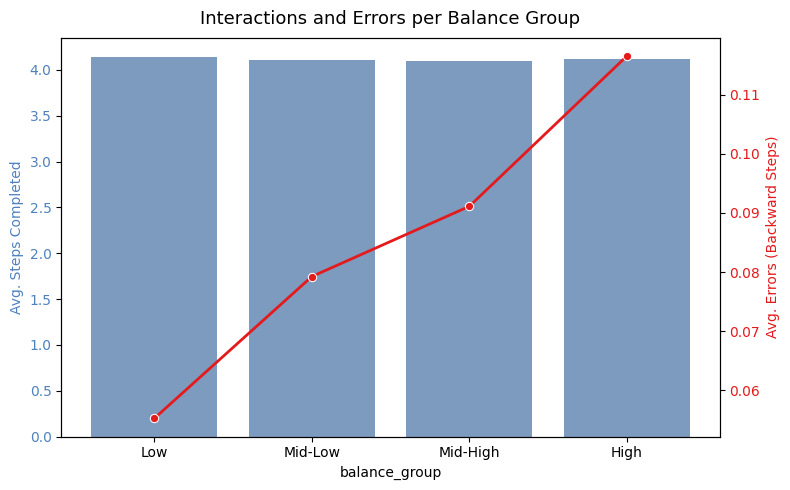

In [28]:
# Aggregate data for visualization
viz = (
    balance_analysis
    .groupby("balance_group", observed=False)[["n_steps", "n_errors"]]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(8,5))

# Bars: Average Steps
sns.barplot(data=viz, x="balance_group", y="n_steps", color="#4F81BD", alpha=0.8, ax=ax1)
ax1.set_ylabel("Avg. Steps Completed", color="#4F81BD")
ax1.tick_params(axis="y", labelcolor="#4F81BD")

# Line: Average Errors
ax2 = ax1.twinx()
sns.lineplot(data=viz, x="balance_group", y="n_errors", color="#E41A1C", marker="o", linewidth=2, ax=ax2)
ax2.set_ylabel("Avg. Errors (Backward Steps)", color="#E41A1C")
ax2.tick_params(axis="y", labelcolor="#E41A1C")

# Titles & Layout
plt.title("Interactions and Errors per Balance Group", fontsize=13, pad=10)
plt.tight_layout()
plt.show()


## Final Conclusion 

The statistical tests confirm that error rates differ significantly between balance groups
(ANOVA: F = 132.51, p < 0.001; Kruskal–Wallis: H = 365.98, p < 0.001).

However, the actual magnitude of these differences is minimal — from an average of approximately 0.09 to 0.20 backward steps per client — suggesting that while the difference is statistically detectable due to the large sample size, its practical impact is negligible.

In contrast, the number of steps completed does not vary meaningfully across balance groups (ANOVA returned NaN, indicating no valid variance across groups).

Overall conclusion:
Account balance shows no substantial influence on user behavior during the onboarding process.
Wealthier clients are not more efficient nor more error-prone than others, though they may exhibit slightly more cautious navigation (a small increase in backtracking activity).